<a href="https://colab.research.google.com/github/pmama/TSA/blob/main/AirlinePassenger_Sarimax_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Time Series Analysis of Airline Data**
```
# This is formatted as code
```



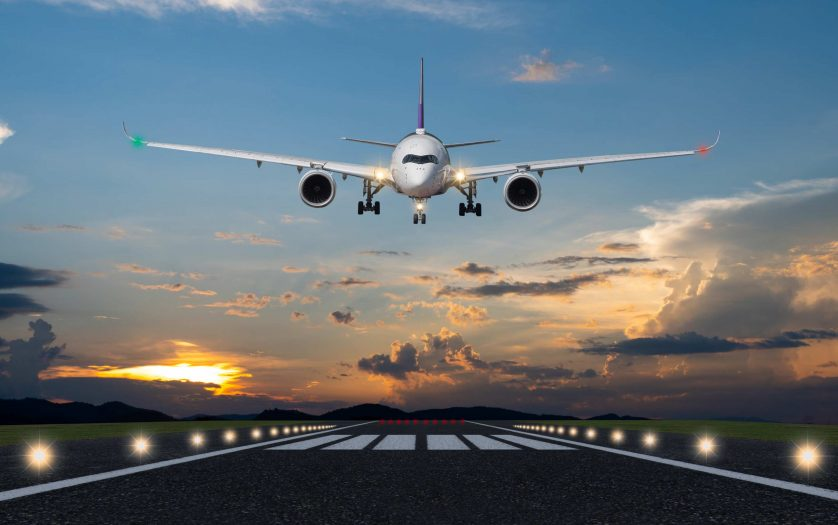

### **About Dataset**
This dataset provides monthly totals of a US airline passengers from 1949 to 1960.

- This is a non-stationary time series data. There are two ways to deal with such kind of data;
> 1. Remove unit-root, convert the time series into stationary and build ARIMA or SARIMA model.
> 2.Without removing unit root, we can implement other model which deal with non-statioary data, like Facebook Prophet model.

# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from numpy import log
import warnings
warnings.filterwarnings('ignore')

# **Loading Data**

In [2]:
from google.colab import files
files.upload()

Saving airline_passengers.csv to airline_passengers.csv


{'airline_passengers.csv': b'Month,Thousands of Passengers,Lag1\r\n1949-01,112,\r\n1949-02,118,112\r\n1949-03,132,118\r\n1949-04,129,132\r\n1949-05,121,129\r\n1949-06,135,121\r\n1949-07,148,135\r\n1949-08,148,\r\n1949-09,136,\r\n1949-10,119,\r\n1949-11,104,\r\n1949-12,118,\r\n1950-01,115,\r\n1950-02,126,\r\n1950-03,141,\r\n1950-04,135,\r\n1950-05,125,\r\n1950-06,149,\r\n1950-07,170,\r\n1950-08,170,\r\n1950-09,158,\r\n1950-10,133,\r\n1950-11,114,\r\n1950-12,140,\r\n1951-01,145,\r\n1951-02,150,\r\n1951-03,178,\r\n1951-04,163,\r\n1951-05,172,\r\n1951-06,178,\r\n1951-07,199,\r\n1951-08,199,\r\n1951-09,184,\r\n1951-10,162,\r\n1951-11,146,\r\n1951-12,166,\r\n1952-01,171,\r\n1952-02,180,\r\n1952-03,193,\r\n1952-04,181,\r\n1952-05,183,\r\n1952-06,218,\r\n1952-07,230,\r\n1952-08,242,\r\n1952-09,209,\r\n1952-10,191,\r\n1952-11,172,\r\n1952-12,194,\r\n1953-01,196,\r\n1953-02,196,\r\n1953-03,236,\r\n1953-04,235,\r\n1953-05,229,\r\n1953-06,243,\r\n1953-07,264,\r\n1953-08,272,\r\n1953-09,237,\r\n195

# **Reading Data**

In [5]:
df  = pd.read_csv('airline_passengers.csv')
df = df[['Month','Thousands of Passengers']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


# **Preprocessing of TSA**
 #### **Step -1:** The first step in time series analysis (TSA) often involves preparing and transforming the date-related data. This typically includes ensuring that the date column is correctly formatted and set as the index, as well as making sure the time intervals between data points are consistent. Once the date is correctly handled, you can proceed with further TSA tasks like trend and seasonality analysis, data decomposition, and modeling.

In [ ]:
df.Month = pd.to_datetime(df.Month)
df.info()

In [6]:
df.set_index('Month', inplace = True)
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
df['Thousands of Passengers']= pd.to_numeric(df['Thousands of Passengers'], errors='coerce', downcast='integer')

<Axes: ylabel='Density'>

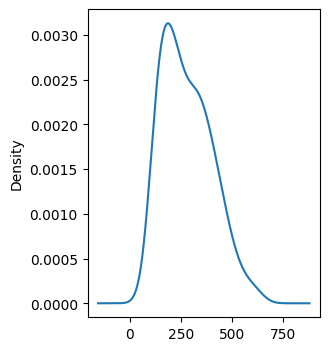

In [9]:
df['Thousands of Passengers'].plot(kind ='kde', figsize=(3,4))

In [10]:
df.isnull().sum()

Thousands of Passengers    0
dtype: int64

In [11]:
original_data = df['Thousands of Passengers']

### **Step-2 : Check AutoCorrelation (Durbin Watson Test)**

- Auto-correlation refers to correlation of time series with its own past and future values


The Durbin-Watson test is a statistical test used to detect the presence of autocorrelation in the residuals of a regression or time series model. The test statistic of the Durbin-Watson test falls in the range between 0 and 4. Here's what the test statistic values indicate:

- A value close to 2 (typically between 1.5 and 2.5) indicates no significant autocorrelation. This is the desired result, indicating that the residuals are independent.

- A value significantly less than 2 (approaching 0) indicates positive autocorrelation, which means that there is a positive relationship between the residuals at different lags.

- A value significantly greater than 2 (approaching 4) indicates negative autocorrelation, which means that there is a negative relationship between the residuals at different lags.

In [12]:
import statsmodels.api as sm
dw_test = sm.stats.durbin_watson(original_data)
print('Result of DW Test : ',dw_test)
if abs(dw_test) <= 1.5 or abs(dw_test) > 2.5:
  print('Auto-Correlation is detected')

Result of DW Test :  0.6142959207974688
Auto-Correlation is detected


- For Durbin Watson values falling within the range of 1.5 to 2.5, it suggests that classical time series analysis (TSA) may not be the ideal approach. Instead, linear regression would be more suitable to handle the data.
- The Durbin-Watson test statistic of **0.6142959207974688** falls significantly below the range of 1.5 to 2.5. This result indicates that there is a noticeable positive autocorrelation within the residuals. In simpler terms, it means that the residuals are not independent, and there is a clear positive association between the residuals at various lag points in your model. As a consequence, we can conclude that time series forecasting might be a more appropriate approach to handle the data.



If autocorrelation is detected, it may be necessary to address it. Common approaches include:

- **Include Lagged Variables**: If the time series data exhibits autocorrelation, you can include lagged values of the dependent variable as predictors in your model.

- **Differencing**: Differencing the time series data can remove autocorrelation. You can difference the data once or multiple times until the residuals are no longer correlated.

- **Autoregressive (AR) Models**: Autoregressive models explicitly model the autocorrelation in the data. You can consider using ARIMA or SARIMA models to capture and account for the autocorrelation.

- **Time Series Smoothing**: Applying smoothing techniques, such as moving averages or exponential smoothing, can reduce the impact of autocorrelation.

- Transformations: Data transformations, such as taking the logarithm or square root, can help stabilize variance and reduce autocorrelation.

### **Step-3: Check Stationarity of Time Series**

> 1. Visualisation
> 2. Global vs Local Approach
> 3. Rolling Window Visualisation
> 3. Hypothesis Test (Augmented Dickey Fuller Test, KPSS Test)

##### **Check-1: Visualisation**


<Axes: xlabel='Month'>

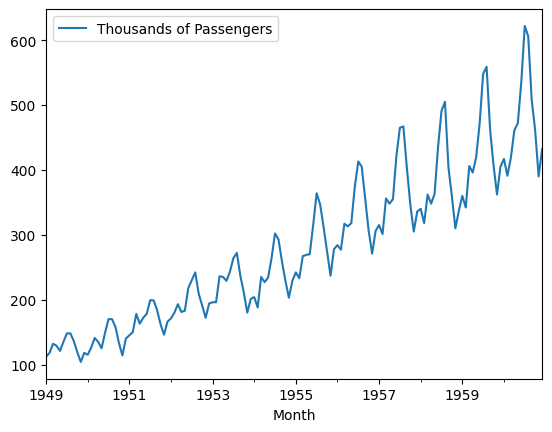

In [13]:
df.plot()

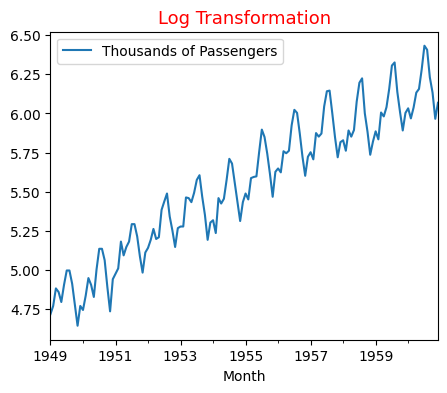

In [14]:
# Log Transformation
df_log =df.copy()
df_log['Thousands of Passengers'] = np.log(original_data)
df_log.plot(figsize=(5,4))
plt.title('Log Transformation', fontsize= 13, color ='red')
plt.show()

**Check  Components of TSA (Trend, Seasonality, Residual)**

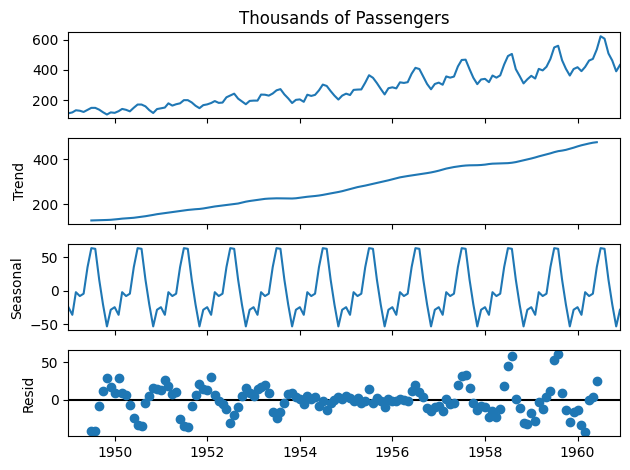

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_add = seasonal_decompose(original_data, model = 'additive', period =12)
decompose_add.plot()
plt.show()

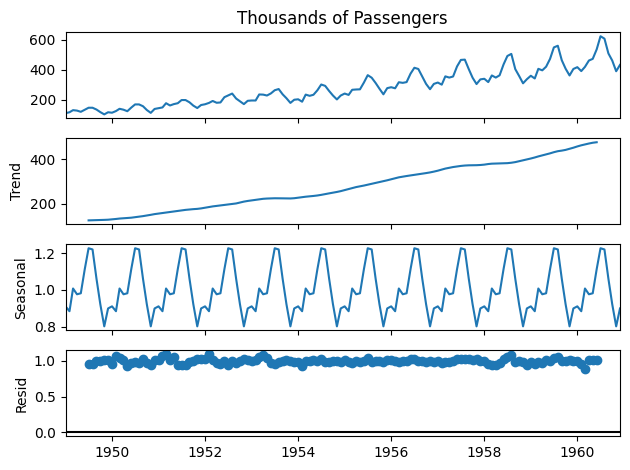

In [16]:
decompose_mul = seasonal_decompose(original_data, model = 'multiplicative', period =12)
decompose_mul.plot()
plt.show()

In [17]:
print('===='*20)
print("   Decomposition can't accurately represents the original observed value.")
print('===='*20)
for i in range(len(df)):
    trend = decompose_add.trend[i]
    seasonality = decompose_add.seasonal[i]
    resid = decompose_add.resid[i]
    sum_decom = trend + seasonality + resid
    Obsv = original_data[i]


#     print(f'Trend (Tt): {trend}')
#     print(f'Seasonality (St): {seasonality}')
#     print(f'Residual (Rt): {resid}')

    if sum_decom != Obsv:
        print(f'Data Point {i + 1}')

#     else:
#         print(' ')

   Decomposition can't accurately represents the original observed value.
Data Point 1
Data Point 2
Data Point 3
Data Point 4
Data Point 5
Data Point 6
Data Point 43
Data Point 139
Data Point 140
Data Point 141
Data Point 142
Data Point 143
Data Point 144


#### **Check-2: Global Vs. Local Approach**

In [18]:
global_mean = original_data.mean()
print('Local means of TSA ;' , global_mean)

Local means of TSA ; 280.2986111111111


In [19]:
monthly_segments = original_data.resample('y').sum()

local_means = []
for segment in monthly_segments:
    #print(segment)
    local_mean = np.mean(segment)
    local_means.append(local_mean)
print('Local means of TSA ;' , local_means)

Local means of TSA ; [1520.0, 1676.0, 2042.0, 2364.0, 2700.0, 2867.0, 3408.0, 3939.0, 4421.0, 4572.0, 5140.0, 5714.0]


A noticeable difference exists between the global mean and local mean, indicating a significant disparity in the observed data.

#### **Check-3: Rolling Window Visualisation**
Look for patterns in the data:

- If the rolling mean remains relatively constant over time and the rolling standard deviation doesn't show significant variations, the time series is likely stationary.
- If the rolling mean has a clear trend or if the rolling standard deviation exhibits large fluctuations, it may indicate non-stationarity.

In [20]:
def Rolling_Test_stationarity(ts, windows = 7):
    mean_rolling = ts.rolling(window = windows).mean()
    std_rolling = ts.rolling(window = windows).std()

    ts.plot(color ='skyblue', label='Original')
    mean_rolling.plot(color ='orange', label='Rolling Mean')
    std_rolling.plot(color ='indigo', label='Rolling Std')
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

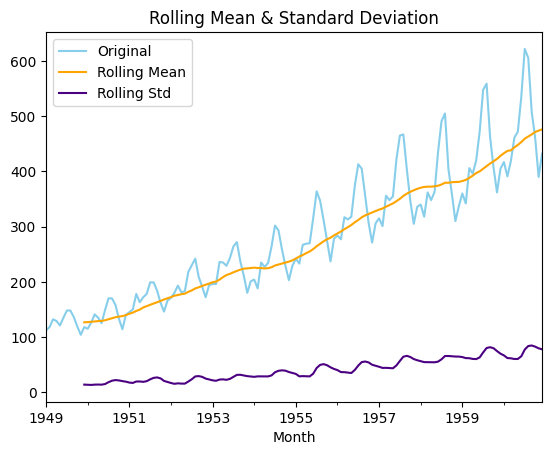

In [22]:
Rolling_Test_stationarity(original_data, 12)

### **Step :4 Hypothesis Test (Checking P-value)**

- $H_{0}$ : Fails to reject Null hypothesis. TS is non- Stationary.
- $H_{1}$ : Rejects the Null hypothesis. TS is  Stationary.

- `Augmented Dickey Fuller Test (ADFuller Test)`


-  **1. Augmented Dickey Fuller Test (ADFuller Test)**

In [23]:
from statsmodels.tsa.stattools import adfuller
def adf_test_summary(data):
    print('==='*20)
    print('The summary of Augmented Dickey Fuller test is :')

    labels =['ADFullerTest_statistics', 'P_value', 'No. of Lags_used',
             'No. of Observation_used', 'critical_values',
             'Maximized Information Criterion (AIC or BIC)' ]

    print('==='*20)
    ts = data
    adf_test = adfuller(ts)
    P_value = adf_test[1]

    for label, res in zip(labels,adf_test):
        print (f'{label} :{res}' )

    print()
    print('==='*20)
    print('Checking Stationary:')
    print('==='*20)
    if P_value <= 0.05:
        print('P_value', P_value, ': P_value  ≤ 0.05 ')
        print('Strong Evidence against Null Hypothesis')
        print('Time Series is Stationary')
    else:
        print('P_value =', P_value, ': P_value > 0.05 ')
        print('Weak Evidence against Null Hypothesis')
        print('Time Series is Non-Stationary')



In [24]:
adf_test_summary(original_data)

The summary of Augmented Dickey Fuller test is :
ADFullerTest_statistics :0.8153688792060498
P_value :0.991880243437641
No. of Lags_used :13
No. of Observation_used :130
critical_values :{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Maximized Information Criterion (AIC or BIC) :996.692930839019

Checking Stationary:
P_value = 0.991880243437641 : P_value > 0.05 
Weak Evidence against Null Hypothesis
Time Series is Non-Stationary


# **Converting Time Series Data Stationary by Differencing:**

#### **1. Trend Differencing**

##### **1st Differencing**

In [26]:
#df['diff1'] = original_data - original_data.shift(1)
diff_data1= original_data.diff()
adf_test_summary(diff_data1.dropna())

The summary of Augmented Dickey Fuller test is :
ADFullerTest_statistics :-2.8292668241700047
P_value :0.05421329028382478
No. of Lags_used :12
No. of Observation_used :130
critical_values :{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Maximized Information Criterion (AIC or BIC) :988.5069317854085

Checking Stationary:
P_value = 0.05421329028382478 : P_value > 0.05 
Weak Evidence against Null Hypothesis
Time Series is Non-Stationary


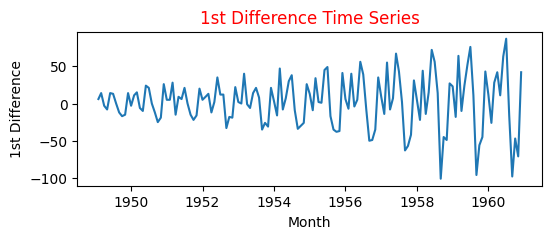

In [27]:
plt.figure(figsize=(6, 2))
plt.plot(df.index, diff_data1)
plt.title('1st Difference Time Series',  fontsize=12, color='red')
plt.xlabel('Month')
plt.ylabel('1st Difference', )
plt.show()

##### **2nd Differencing**

In [28]:
diff_data2= diff_data1.diff()
adf_test_summary(diff_data2.dropna())

The summary of Augmented Dickey Fuller test is :
ADFullerTest_statistics :-16.384231542468513
P_value :2.7328918500142026e-29
No. of Lags_used :11
No. of Observation_used :130
critical_values :{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Maximized Information Criterion (AIC or BIC) :988.6020417275611

Checking Stationary:
P_value 2.7328918500142026e-29 : P_value  ≤ 0.05 
Strong Evidence against Null Hypothesis
Time Series is Stationary


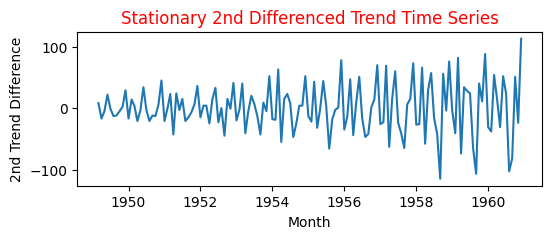

In [29]:
plt.figure(figsize=(6, 2))
plt.plot(df.index, diff_data2, )
plt.title('Stationary 2nd Differenced Trend Time Series', fontsize=12, color='red')
plt.xlabel('Month')
plt.ylabel('2nd Trend Difference')
plt.show()

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

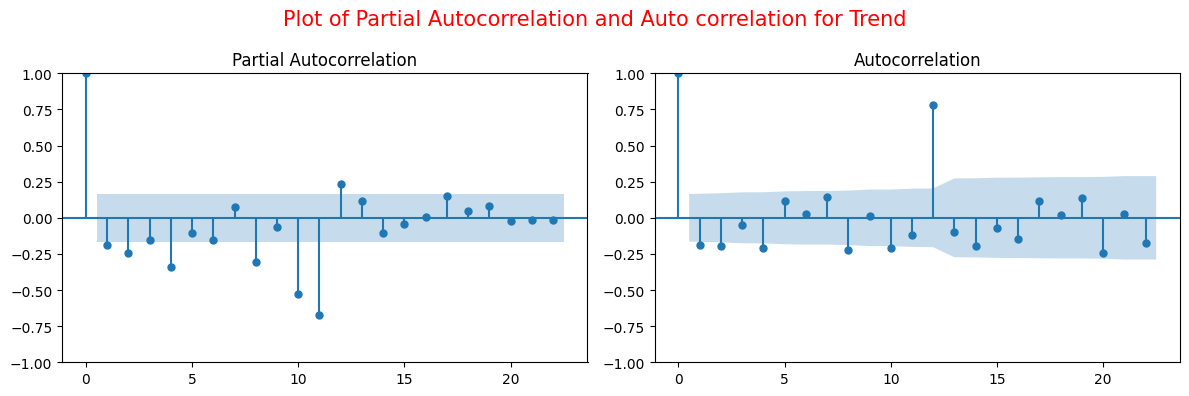

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle('Plot of Partial Autocorrelation and Auto correlation for Trend', fontsize = 15, color = 'red' )
plot_pacf(diff_data2.dropna(), ax = ax1)
plot_acf(diff_data2.dropna(), ax = ax2)
plt.tight_layout()
plt.show()

- #### Trend (p,d,q)
> - p : Partial Auto Correlation
> - d : differncing
> - q : Auto Correlation

    
Here we've found

> - p = 4
> - d = 2
> - q = 2


##### # **Trend parameters(pdq)**

In [34]:
p, d, q =4,2,2
trend_order = (p, d, q)
print('Parameters for Trend:' , trend_order)

Parameters for Trend: (4, 2, 2)


### **2. Seasonality Difference**

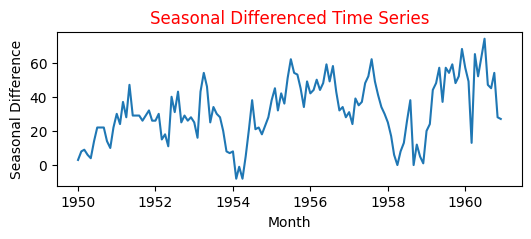

In [35]:
seasonal = original_data.diff(periods=12)
plt.figure(figsize=(6, 2))
plt.plot(df.index, seasonal)
plt.title('Seasonal Differenced Time Series',  fontsize=12, color='red')
plt.xlabel('Month')
plt.ylabel('Seasonal Difference', )
plt.show()


#### # stationarity check of seasionality

In [36]:
adf_test_summary(seasonal.dropna())

The summary of Augmented Dickey Fuller test is :
ADFullerTest_statistics :-3.383020726492481
P_value :0.011551493085514952
No. of Lags_used :1
No. of Observation_used :130
critical_values :{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Maximized Information Criterion (AIC or BIC) :919.527129208137

Checking Stationary:
P_value 0.011551493085514952 : P_value  ≤ 0.05 
Strong Evidence against Null Hypothesis
Time Series is Stationary


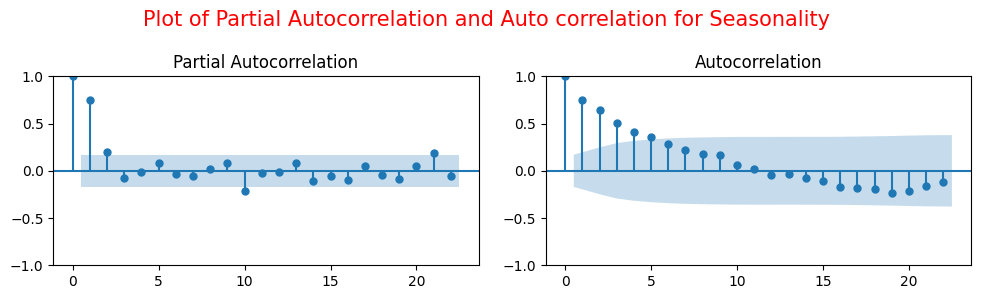

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle('Plot of Partial Autocorrelation and Auto correlation for Seasonality', fontsize = 15, color = 'red' )
plot_pacf(seasonal.dropna(), ax = ax1)
plot_acf(seasonal.dropna(), ax = ax2)
plt.tight_layout()
plt.show()

- #### #seasonality(P,D,Q, m)
> - P : Partial Auto Correlation
> - Q : Auto Correlation
> - D : differncing
> - m : 12
    
Here we've found

> - P = 2
> - Q = 5
> - D = 1
> - m = 12

### Seasonality parameters (PDQm)

In [38]:
P,D,Q,m = 2, 1, 5, 12
seasonal_order = (P,D,Q,m)
print('Parameters for Trend:' , seasonal_order)

Parameters for Trend: (2, 1, 5, 12)


# **Model Building**

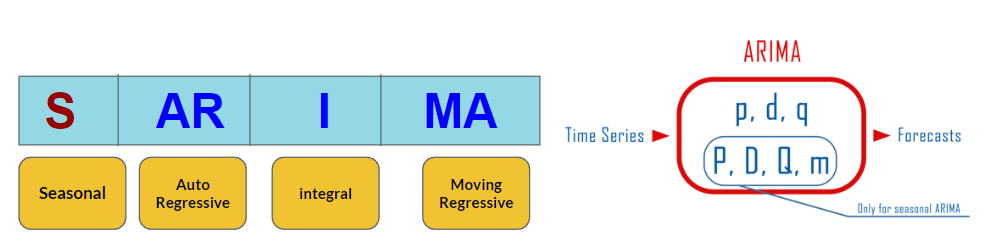

In [40]:
from statsmodels.tsa.arima_model import ARIMA
print(f'trend_order :{trend_order}')
print(f'seasonal_order :{seasonal_order}')
model = sm.tsa.statespace.SARIMAX(original_data, order = trend_order,
                                 seasonal_order= seasonal_order)

trend_order :(4, 2, 2)
seasonal_order :(2, 1, 5, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
result = model.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                          Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.714
Date:                                          Fri, 20 Oct 2023   AIC                           1021.428
Time:                                                  14:06:30   BIC                           1061.573
Sample:                                              01-01-1949   HQIC                          1037.740
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3420      0.089    -15.079      0.000      -1.516      -1.168
ar.L2         -0.4627      0.139     -3.326      0.001      -0.735      -0.190
ar.L3         -0.1341      0.180     -0.745      0.457      -0.487       0.219
ar.L4         -0.0914      0.098     -0.936      0.349      -0.283       0.100
ma.L1         -0.0057      7.950     -0.001      0.999     -15.588      15.577
ma.L2         -0.9943      7.908     -0.126      0.900     -16.494      14.506
ar.S.L12       1.0729      2.827      0.379      0.704      -4.469       6.615
ar.S.L24      -0.1818      2.759     -0.066      0.947      -5.589       5.226
ma.S.L12      -1.4133      4.949     -0.286      0.775     -11.113       8.286
ma.S.L24       0.6341      5.212      0.122      0.903      -9.582      10.850
ma.S.L36      -0.1849      1.164     -0.159      0.874      -2.466       2.096
ma.S.L48       0.1778      1.165      0.153      0.879      -2.105       2.460
ma.S.L60       0.0807      0.508      0.159      0.874      -0.915       1.076
sigma2        95.3132    801.551      0.119      0.905   -1475.698    1666.325
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                11.08
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
Q = 1
seasonal_order = (P,D,Q,m)
print(seasonal_order)
arima5 = sm.tsa.statespace.SARIMAX(original_data, order = trend_order,
                                 seasonal_order= seasonal_order)
result5 = arima5.fit()
result5.summary()

(2, 1, 1, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.785
Date:                              Fri, 20 Oct 2023   AIC                           1015.569
Time:                                      14:09:26   BIC                           1044.245
Sample:                                  01-01-1949   HQIC                          1027.221
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3590      0.097    -14.045      0.000      -1.549      -1.169
ar.L2         -0.4918      0.145     -3.380      0.001      -0.777      -0.207
ar.L3         -0.1168      0.172     -0.678      0.498      -0.455       0.221
ar.L4         -0.0681      0.097     -0.704      0.482      -0.258       0.122
ma.L1         -0.0023      3.119     -0.001      0.999      -6.115       6.110
ma.L2         -0.9977      3.168     -0.315      0.753      -7.206       5.211
ar.S.L12       0.6822      0.177      3.849      0.000       0.335       1.030
ar.S.L24       0.3157      0.104      3.043      0.002       0.112       0.519
ma.S.L12      -0.9665      1.069     -0.904      0.366      -3.062       1.129
sigma2       104.5985    309.841      0.338      0.736    -502.679     711.876
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                12.62
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **AIC value is least for Q = 1**

In [43]:
final_result = result5

### **Evaluation of Model**

In [44]:
# validate
df['Forecast'] = final_result.predict( start = len(df)-20, end = len(df), dynamic = True )
forecast_data= df.Forecast
df.tail()

,Thousands of Passengers,Forecast
Month,,
1960-08-01,606,602.607995
1960-09-01,508,496.611099
1960-10-01,461,441.281931
1960-11-01,390,389.465402
1960-12-01,432,418.203995


### **Measurements**

In [55]:
actual_values = original_data.iloc[len(df)-20: len(df)+1]
forecasted_values = df['Forecast'].iloc[len(df)-20: len(df)+1]


mae = np.mean(np.abs(actual_values - forecasted_values))
mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values))
squared_errors = (actual_values - forecasted_values) ** 2
mse = np.mean(squared_errors)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape *100:.3f}%")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 12.967982898042342
Mean Absolute Percentage Error (MAPE): 2.816%
Mean Squared Error (MSE): 247.38739697118848
Root Mean Squared Error (RMSE): 15.72855355622978


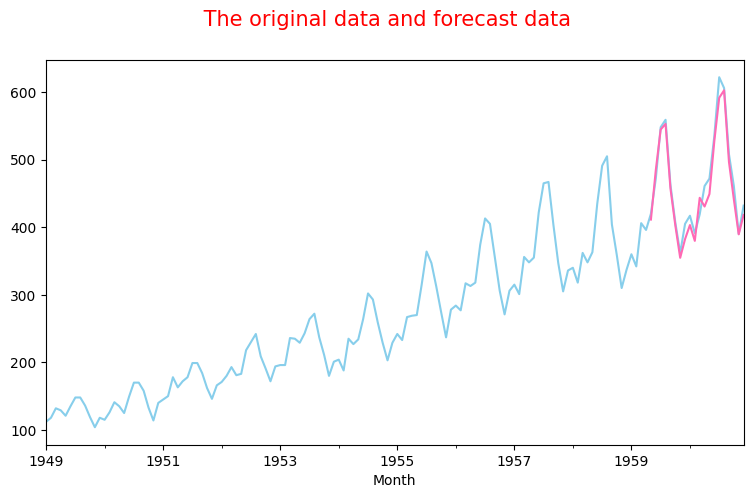

In [46]:
#visualise
fig, ax = plt.subplots(figsize=(9, 5))
plt.suptitle(' The original data and forecast data', fontsize =15, color = 'red')
original_data.plot(color='skyblue', ax=ax, label='Original Data')
forecast_data.plot(color='hotpink', ax=ax, label='Forecast')
plt.show()

### **Future Prection (5 years monthwise)**







In [47]:
from pandas.tseries.offsets import DateOffset
base_date =df.index[-1]
years = 5
print(base_date)
print('==='*10)
future_dates = [base_date + DateOffset(months=x) for x in range(0,(years*12)+1)]
future_dates[-1]

1960-12-01 00:00:00


Timestamp('1965-12-01 00:00:00')

In [48]:
df.columns

Index(['Thousands of Passengers', 'Forecast'], dtype='object')

In [49]:
new_df =pd.DataFrame(index = future_dates, columns = df.columns)

new_df.head()

,Thousands of Passengers,Forecast
1960-12-01,NaN,NaN
1961-01-01,NaN,NaN
1961-02-01,NaN,NaN
1961-03-01,NaN,NaN
1961-04-01,NaN,NaN


In [50]:
new_df.index

DatetimeIndex(['1960-12-01', '1961-01-01', '1961-02-01', '1961-03-01',
               '1961-04-01', '1961-05-01', '1961-06-01', '1961-07-01',
               '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01',
               '1961-12-01', '1962-01-01', '1962-02-01', '1962-03-01',
               '1962-04-01', '1962-05-01', '1962-06-01', '1962-07-01',
               '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01',
               '1962-12-01', '1963-01-01', '1963-02-01', '1963-03-01',
               '1963-04-01', '1963-05-01', '1963-06-01', '1963-07-01',
               '1963-08-01', '1963-09-01', '1963-10-01', '1963-11-01',
               '1963-12-01', '1964-01-01', '1964-02-01', '1964-03-01',
               '1964-04-01', '1964-05-01', '1964-06-01', '1964-07-01',
               '1964-08-01', '1964-09-01', '1964-10-01', '1964-11-01',
               '1964-12-01', '1965-01-01', '1965-02-01', '1965-03-01',
               '1965-04-01', '1965-05-01', '1965-06-01', '1965-07-01',
      

In [51]:
forecast_df = pd.concat([df, new_df])
len(forecast_df)

205

In [52]:
forecast_df.head()

,Thousands of Passengers,Forecast
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN


In [53]:
forecast_df.tail()

,Thousands of Passengers,Forecast
1965-08-01,NaN,NaN
1965-09-01,NaN,NaN
1965-10-01,NaN,NaN
1965-11-01,NaN,NaN
1965-12-01,NaN,NaN


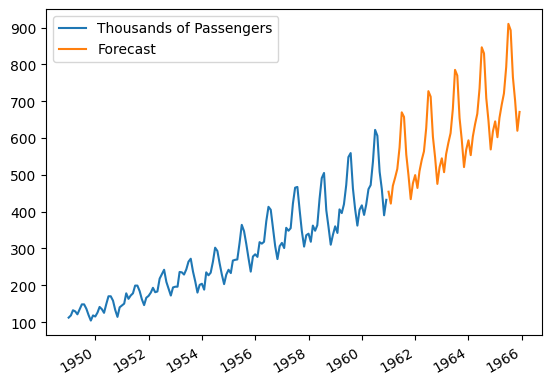

In [56]:
forecast_df['Forecast'] = final_result.predict(start = len(df), end= len(forecast_df), dynamic = True)
forecast_df[['Thousands of Passengers', 'Forecast']].plot()
plt.show()

### **Saving Final Predicted Data**

In [57]:
forecast_df['Forecast'].to_csv('FiveYearsAirlinePassengers.csv')

In [ ]:
#!pip install pystan

In [ ]:
#!python -m pip install prophet

In [58]:
import prophet

In [59]:
dir(prophet)

['Path',
 'Prophet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'about',
 'diagnostics',
 'f',
 'forecaster',
 'here',
 'make_holidays',
 'models',
 'plot']

In [60]:
df = pd.read_csv('airline_passengers.csv')
df = df[['Month','Thousands of Passengers']]
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [61]:
df.tail()

,Month,Thousands of Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


### **Preparing dataframe for prophet model**

In [62]:
df_prophet = df.rename(columns ={'Month' :'ds', 'Thousands of Passengers' :'y'})
df_prophet.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# **Facebook Prophet Model**

In [66]:
from prophet import Prophet
prophet_model = Prophet()
model = prophet_model.fit(df_prophet)
model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fiyvt7p/z0db5mss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fiyvt7p/263cj9qc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85877', 'data', 'file=/tmp/tmp6fiyvt7p/z0db5mss.json', 'init=/tmp/tmp6fiyvt7p/263cj9qc.json', 'output', 'file=/tmp/tmp6fiyvt7p/prophet_modelsro01lre/prophet_model-20231020142938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [65]:
last_date = df_prophet['ds'].tail(1)
last_date

143    1960-12
Name: ds, dtype: object

# Next 5 years Prediction (Monthlywise)

In [67]:
future_pred = model.make_future_dataframe(periods = 61, freq ='m',)
future_pred

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
200,1965-08-31
201,1965-09-30
202,1965-10-31
203,1965-11-30


In [68]:
print('Length of original data', len(df_prophet))
print('Length of new data for prediction', len(future_pred))
print('Length of days added', len(future_pred)-len(df_prophet))

Length of original data 144
Length of new data for prediction 205
Length of days added 61


In [69]:
future_pred.tail()

,ds
200,1965-08-31
201,1965-09-30
202,1965-10-31
203,1965-11-30
204,1965-12-31


In [70]:
prediction = model.predict(future_pred)
prediction.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,107.406338,59.319603,113.664588,107.406338,107.406338,-21.387455,-21.387455,-21.387455,-21.387455,-21.387455,-21.387455,0.0,0.0,0.0,86.018883
1,1949-02-01,109.550561,49.134813,108.873827,109.550561,109.550561,-30.055335,-30.055335,-30.055335,-30.055335,-30.055335,-30.055335,0.0,0.0,0.0,79.495226
2,1949-03-01,111.487279,79.228714,141.831068,111.487279,111.487279,-0.461698,-0.461698,-0.461698,-0.461698,-0.461698,-0.461698,0.0,0.0,0.0,111.025581


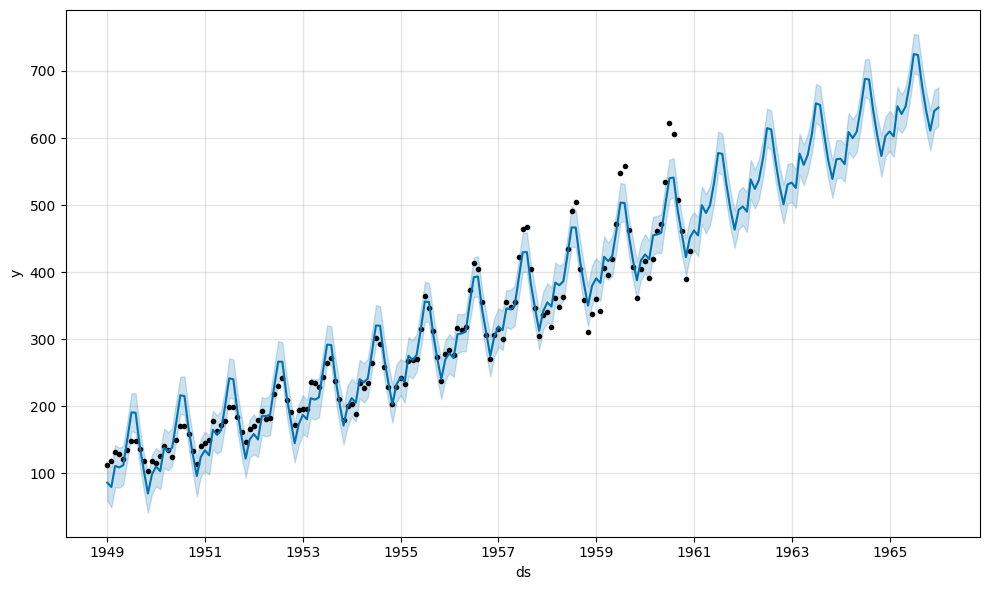

In [71]:
model.plot(prediction)
plt.show()

##### **Changepoints in a time series forecast**

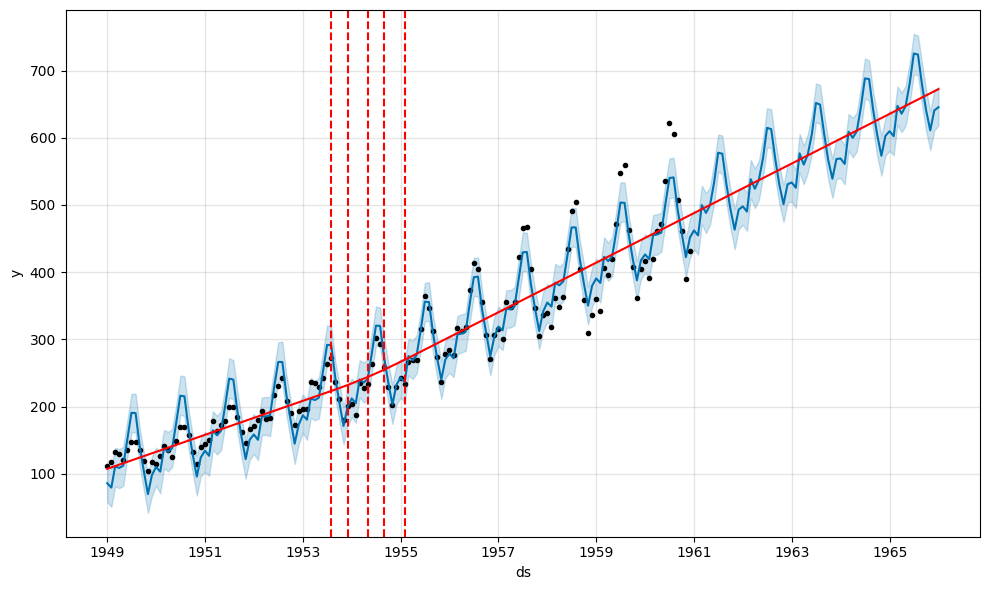

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig =model.plot(prediction)
a =  add_changepoints_to_plot(fig.gca(), model, prediction)
plt.show()

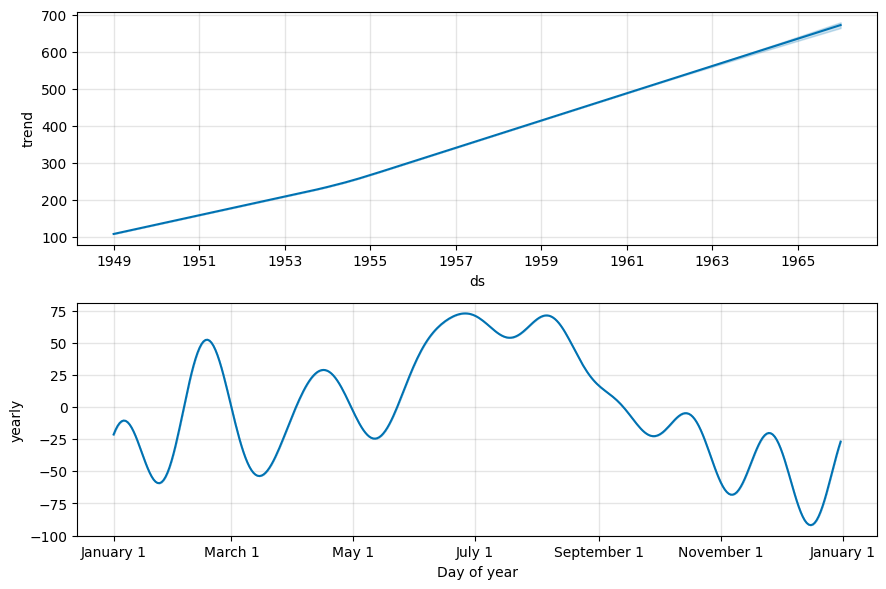

In [ ]:
model.plot_components(prediction)
plt.show()

# **Model Performance**

In [72]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon ='60days', period ='30days', initial='90days')
df_cv

INFO:prophet:Making 141 forecasts with cutoffs between 1949-04-03 00:00:00 and 1960-10-02 00:00:00


  0%|          | 0/141 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fiyvt7p/fxgs8hxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fiyvt7p/cnujeyop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92043', 'data', 'file=/tmp/tmp6fiyvt7p/fxgs8hxp.json', 'init=/tmp/tmp6fiyvt7p/cnujeyop.json', 'output', 'file=/tmp/tmp6fiyvt7p/prophet_model1c_0taiw/prophet_model-20231020143425.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:34:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fiyvt7p/jczjuiw5.json
DEBUG:cmdstanpy:input tempfile

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1949-05-01,619.237536,619.237535,619.237536,121,1949-04-03
1,1949-06-01,5.162364,5.162361,5.162366,135,1949-04-03
2,1949-06-01,1847.091658,1847.091656,1847.091659,135,1949-05-03
3,1949-07-01,755.050316,755.050311,755.050321,148,1949-05-03
4,1949-07-01,-1341.193799,-1341.193799,-1341.193799,148,1949-06-02
...,...,...,...,...,...,...
273,1960-10-01,457.502083,427.197716,487.519691,461,1960-08-03
274,1960-10-01,458.482656,430.099106,486.165370,461,1960-09-02
275,1960-11-01,430.151256,403.069889,460.055057,390,1960-09-02
276,1960-11-01,429.935506,402.948629,457.433334,390,1960-10-02


In [76]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1949-05-01,619.237536,619.237535,619.237536,121,1949-04-03
1,1949-06-01,5.162364,5.162361,5.162366,135,1949-04-03
2,1949-06-01,1847.091658,1847.091656,1847.091659,135,1949-05-03
3,1949-07-01,755.050316,755.050311,755.050321,148,1949-05-03
4,1949-07-01,-1341.193799,-1341.193799,-1341.193799,148,1949-06-02
...,...,...,...,...,...,...
273,1960-10-01,457.502083,427.197716,487.519691,461,1960-08-03
274,1960-10-01,458.482656,430.099106,486.165370,461,1960-09-02
275,1960-11-01,430.151256,403.069889,460.055057,390,1960-09-02
276,1960-11-01,429.935506,402.948629,457.433334,390,1960-10-02


In [77]:
from prophet.diagnostics import performance_metrics
df_performance = performance_metrics(df_cv)

In [78]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,595362.106977,771.597114,209.734471,1.747582,0.088177,0.362010,0.259259
1,8 days,4230.358039,65.041203,38.315603,0.257483,0.084024,0.238886,0.259259
2,9 days,1461.251338,38.226317,24.338538,0.136382,0.073186,0.158919,0.244444
3,10 days,1441.344715,37.965046,24.070396,0.131333,0.063879,0.154268,0.259259
4,11 days,1515.246629,38.926169,25.822205,0.129870,0.070605,0.154501,0.148148
5,12 days,1287.909293,35.887453,23.198957,0.113239,0.070605,0.141440,0.185185
6,13 days,495.877319,22.268303,16.633544,0.059587,0.062086,0.059448,0.259259
7,14 days,566.654040,23.804496,17.908320,0.060156,0.062086,0.058944,0.290123
8,15 days,623.168075,24.963335,19.444013,0.061826,0.062086,0.060784,0.259259
9,16 days,795.466920,28.204023,23.058824,0.071275,0.084191,0.070276,0.222222


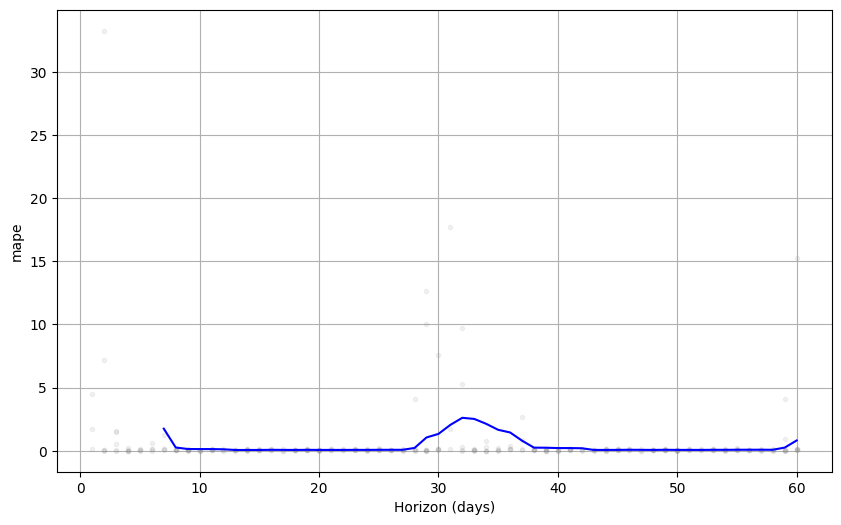

In [79]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric ='mape')
plt.show()

In [80]:
forecast_df

,Thousands of Passengers,Forecast
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1965-08-01,NaN,892.700768
1965-09-01,NaN,764.953798
1965-10-01,NaN,701.696971
1965-11-01,NaN,619.633123


In [81]:
fb_prophet_forecast = df_cv [['y','yhat']]
fb_prophet_forecast

,y,yhat
0,121,619.237536
1,135,5.162364
2,135,1847.091658
3,148,755.050316
4,148,-1341.193799
...,...,...
273,461,457.502083
274,461,458.482656
275,390,430.151256
276,390,429.935506


In [82]:
sarima_pred = pd.concat([actual_values,forecasted_values], axis =1)
sarima_pred

,Thousands of Passengers,Forecast
Month,,
1959-05-01,420,411.328664
1959-06-01,472,484.579216
1959-07-01,548,544.584755
1959-08-01,559,552.915015
1959-09-01,463,457.660573
1959-10-01,407,402.828550
1959-11-01,362,354.718434
1959-12-01,405,382.436359
1960-01-01,417,403.221136


In [88]:
fb_prophet_pred = prediction.iloc[123:143,-1].values
fb_prophet_df = pd.DataFrame({'Prophet_Forecast' : fb_prophet_pred}, index =sarima_pred.index)
fb_prophet_df

,Prophet_Forecast
Month,
1959-05-01,416.402244
1959-06-01,424.259772
1959-07-01,462.016296
1959-08-01,503.663259
1959-09-01,503.142208
1959-10-01,455.891993
1959-11-01,419.668018
1959-12-01,387.848189
1960-01-01,417.469473


In [89]:
pred_Sarima_prophet = pd.concat([sarima_pred, fb_prophet_df] , axis =1)
pred_Sarima_prophet

,Thousands of Passengers,Forecast,Prophet_Forecast
Month,,,
1959-05-01,420,411.328664,416.402244
1959-06-01,472,484.579216,424.259772
1959-07-01,548,544.584755,462.016296
1959-08-01,559,552.915015,503.663259
1959-09-01,463,457.660573,503.142208
1959-10-01,407,402.828550,455.891993
1959-11-01,362,354.718434,419.668018
1959-12-01,405,382.436359,387.848189
1960-01-01,417,403.221136,417.469473


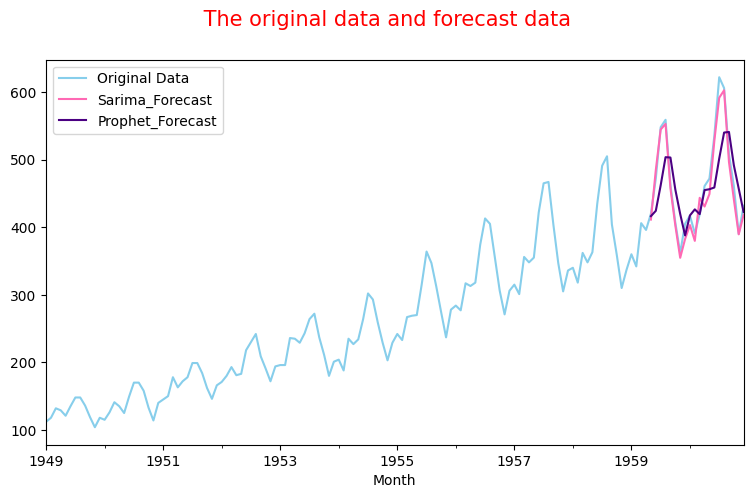

In [91]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.suptitle(' The original data and forecast data', fontsize =15, color = 'red')
original_data.plot(color='skyblue', ax=ax, label='Original Data')
pred_Sarima_prophet['Forecast'].plot(color='hotpink', ax=ax, label='Sarima_Forecast')
pred_Sarima_prophet['Prophet_Forecast'].plot(color='indigo', ax=ax, label='Prophet_Forecast')
plt.legend()
plt.show()